In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# === Diretório e parâmetros ===
data_dir = r'D:\Main dataset'  # substitua conforme necessário
img_size = (224, 224)
batch_size = 32
epochs_finetune = 2
total_epochs = 4

In [ ]:
# === Data augmentation + normalização ===
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


preprocessing = tf.keras.Sequential([
    layers.Rescaling(1./255),  # Normaliza para [0,1]
    layers.Lambda(preprocess_input)  # Aplica normalização do MobileNetV2
])

In [4]:
# === Carregar datasets ===
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'  # rótulo como inteiro
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'
)

Found 2598 files belonging to 1 classes.
Using 2079 files for training.
Found 2598 files belonging to 1 classes.
Using 519 files for validation.


In [5]:
# === Normalizar rótulos para [0, 1] ===
def scale_labels(x, y):
    y = tf.cast(y, tf.float32) / 5.0  # Normaliza para [0,1]
    return x, y

train_ds = train_ds.map(scale_labels).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(scale_labels).prefetch(tf.data.AUTOTUNE)

In [ ]:
# === Base model ===
base_model = MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet')
base_model.trainable = False  # congela no começo

In [7]:
# === Modelo completo ===
model = models.Sequential([
    data_augmentation,
    preprocessing,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='linear')  # Previsão contínua
])

In [8]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [9]:
# === Treinar etapa 1: base congelada ===
print("Treinando com base congelada...")
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs_finetune)

# === Fine-tuning: destrava a base ===
print("Fine-tuning...")
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='mse', metrics=['mae'])

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs - epochs_finetune
)


Treinando com base congelada...
Epoch 1/2

65/65 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - loss: 0.5254 - mae: 0.5265 - val_loss: 0.0112 - val_mae: 0.1053
Epoch 2/2
65/65 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - loss: 0.0436 - mae: 0.1682 - val_loss: 0.0072 - val_mae: 0.0839
Fine-tuning...
Epoch 1/2
65/65 ━━━━━━━━━━━━━━━━━━━━ 605s 9s/step - loss: 0.1069 - mae: 0.2608 - val_loss: 0.0702 - val_mae: 0.2642
Epoch 2/2
65/65 ━━━━━━━━━━━━━━━━━━━━ 575s 9s/step - loss: 0.0884 - mae: 0.2375 - val_loss: 0.0516 - val_mae: 0.2264


In [10]:
model.evaluate(val_ds)

# Save the trained model
model.save("image_classifier_model_v2.h5")

17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 0.0512 - mae: 0.2255


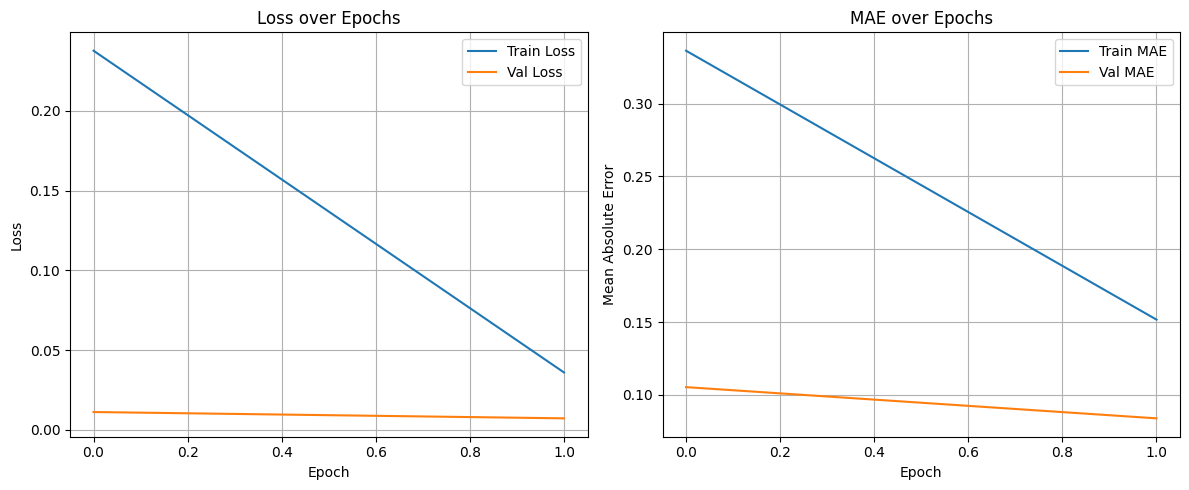

In [11]:
#ARRUMA ISSO AQUI ANTES

import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()